<a href="https://colab.research.google.com/github/IEXE-Tec/aprendizaje-maquina-2/blob/master/04_entrenamiento_de_redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias

In [1]:
#Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# MNIST

## Lectura de datos




In [54]:
# Diccionarios de argumentos
args={}
kwargs={}

# Tamano de lote o Batch
args['batch_size']=1000
args['test_batch_size']=1000

# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.01 
# El momento o momentum del descenso por gradiente
args['momentum']=0.5 

# Parametros de Pytorch
# Semilla aleatoria
args['seed']=345 
args['log_interval']=10
# Usar GPU si existe (cuda), de lo contrario cpu.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
args['cuda']= device


Using device: cuda



El siguiente bloque carga los datos, y los divide en entrenamiento y prueba. 


```
torch.utils.data.DataLoader
```
https://pytorch.org/docs/stable/data.html  
Es el metodo que nos permite cargar los datos y preparlos para el entrenamiento y validacion.  
En este caso recibe 3 argumentos.
+ **datasets.MNIST**:= Indica que datos queremos, en este caso MNIST.
+ **batch_size**:= el tamano del lote o del batch de entrenamiento.
+ **shuffle**:= Si queremos barajear nuestro dataset cada epoca.



```
datasets.MNIST
```
https://pytorch.org/docs/stable/torchvision/datasets.html#mnist 
Es el metodo que llama a los datos del MNIST en particular.  
En este caso recibe 4 argumentos
+ **root**:= Directorio donde existe o descargaran las imagenes o datos.
+ **train**:= Si utiliza los datos de entrenamiento o no.
+ **download**:= Si descarga los datos o no. Si los datos ya estan en le directorio especificado por root no descarga.
+ **transform**:= Si aplica transformaciones a las imagenes.



```
transforms.Compose
```
https://pytorch.org/docs/stable/torchvision/transforms.html  
Esta funcion nos permite anidar transformaciones, parecido al metodo sequential que usamos apra construir redes, pero aplicado a transformaciones.  
En este caso pasamos 2 transformaciones:
+ **transform.ToTensor**:= Convierte las imagenes a un tensor, que es el tipo de estructura de datos que utiliza pytorch.
+ **transform.Normalize**:= Normaliza los tensores. Debemos aplicar la misma normalizacion a los datos de entrenamiento que a los de prueba.
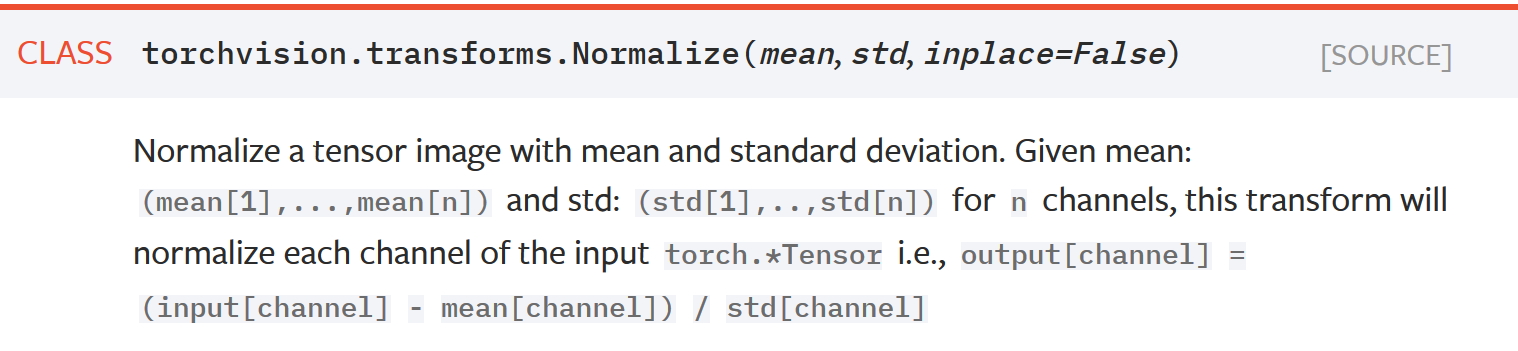






In [3]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], 
    shuffle=True)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


+ Media y desviacion estandard de un solo lote o batch. 
+ Graficar una observacion



Dimension del batch (numero de obs en el batch, canales, altura, ancho)
 torch.Size([1000, 1, 28, 28])

Media del batch:   tensor(0.1306)
Std del batch:   tensor(0.3080)
Contenido de una observacion en formato tensorial 
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.

([], <a list of 0 Text major ticklabel objects>)

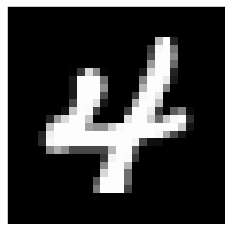

In [4]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print('Dimension del batch (numero de obs en el batch, canales, altura, ancho)\n'
 ,example_data.shape)
print('\nMedia del batch:  ', torch.mean(example_data))
print('Std del batch:  ', torch.std(example_data))
print('Contenido de una observacion en formato tensorial \n', example_data[0][0])

fig = plt.figure()
plt.tight_layout()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])

Veamos la media y desviacion estandard de todos los batches de entrenamiento.

In [5]:
examples = enumerate(train_loader)

# Listas para guardar resultados por batch
batch_mean = []
batch_std = []
batch_labels = []

for batch_idx, (example_data, example_targets) in examples:
  batch_mean.append(torch.mean(example_data).item())
  batch_std.append(torch.std(example_data).item())
  batch_labels.append(example_targets)

# Convertir las etiquetas a numpy array
batch_labels = map(lambda x: x.numpy(), batch_labels )
batch_labels = np.concatenate(list(batch_labels))
batch_labels

array([1, 6, 9, ..., 7, 4, 2])

**Distribucion/balanceo de las etiquetas**

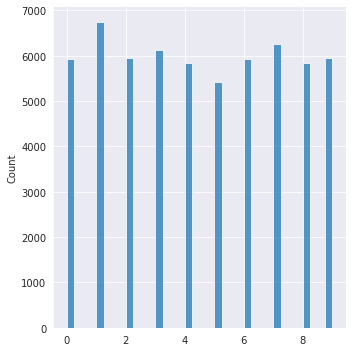

In [6]:
sns.displot(data=batch_labels)

**Histograma de la Media de pixeles**

Media de pixeles:   0.13066047951579093


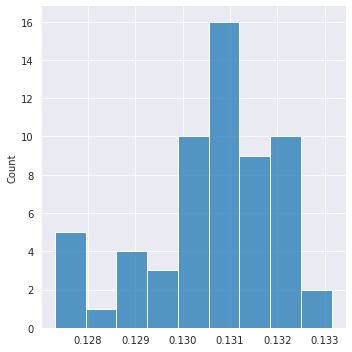

In [7]:
sns.displot(data=batch_mean)
print('Media de pixeles:  ',sum(batch_mean)/len(batch_mean))

**Histograma de la std de los pixeles**

Std de pixeles:   0.3081010500590006


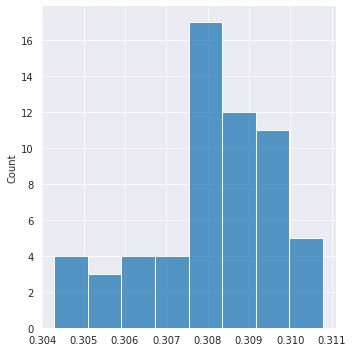

In [8]:
print('Std de pixeles:  ',sum(batch_std)/len(batch_std))
sns.displot(data=batch_std)

Vistazo a los datos de prueba, con y sin normalizacion. En este caso a simple vista no hay mucha diferencia, aun asi es importante normalizar!  
En esta ocasion como las imagenes son en blanco y negro, solo tenemos un canal.

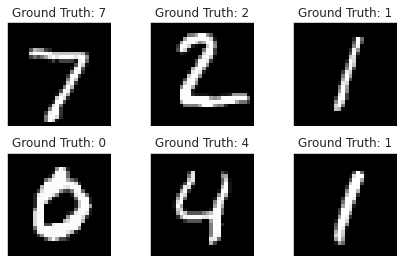

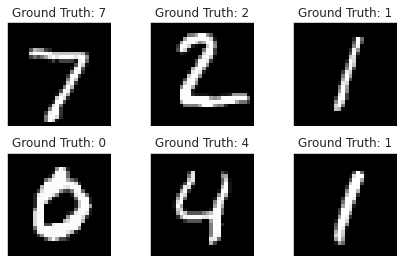

In [9]:

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

torch.Size([1000, 1, 28, 28])


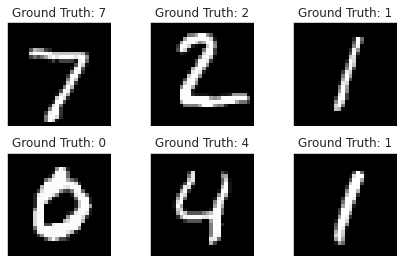

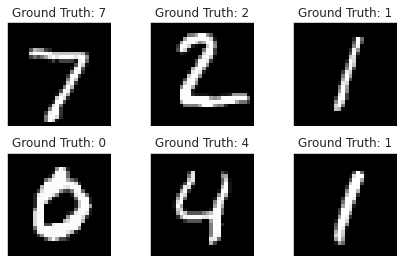

In [10]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Carguemos los datos que utilizaremos, observa que argumentos cambian, respecto a los bloques anteriores.


In [11]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=False, 
                   download = True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=True)

### Resumen de lectura de datos

+ Hemos cargado los datos, y los hemos dividido entre entrenamiento y prueba.
+ Hemo visto la distribucion de las etiquetas (labels) en el entrenamiento, que parece bastante balanceada.
+ Hemos obtenido la media y std de los datos de entrenamiento.
+ Normalizamos los datos.
+ Revisamos la integridad de los datos.  
Hemos realizado con exito el ETL, y parte del EDA

## Definamos la Red Neuronal

Utilizemos el metodo de red neuronal que definimos la clase pasada.

In [12]:
from torch import nn

class RedNeuronal(nn.Module):

    def __init__(self, in_n=784, hidden_n=256, out_n=1):
        super(RedNeuronal, self).__init__()
        
        # W0:= Pesos entrada -> oculta 
        # nn.Linear(neuronas de entrada, neuronas ocultas, bias=True)
        self.hidden = nn.Linear(in_n, hidden_n)

        # W1:= Pesos oculta -> salida 
        # nn.Linear(neuronas ocultas, neuronas salida, bias=True)
        self.output = nn.Linear(hidden_n, out_n)
        
        # Funciones de Activacion 
        # Sigma 1 [capa oculta]
        self.sigmoid = nn.Sigmoid()
        # Sigma 2 [capa de salida]
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Flujo o feedforward de nuestra red

        # Flatten tensores de imagenes
        x = x.view(x.size(0), -1)
        # Multiplicacion de X0 por W0
        x = self.hidden(x)
        # Evaluar Sigma uno / Obtener X1
        x = self.sigmoid(x)
        # Multiplicacion de X1 por W1
        x = self.output(x)
        # Evaluar en Sigma 2 / Obtener X2
        x = self.softmax(x)
        return x

## Definamos la funcion para evaluar nuestro modelo

+ **model.eval**:= Pone al modelo en modo de evaluacion. No calcula el gradiente, y desactiva el comportamiento de entrenamiento. Por ejemplo, descativa el dropout de neuronas.
+ **.cuda()** = carga el tensor al GPU
+ **F.nll_loss**:= Funcion negative log-likelihood 
+ **output.data.max**:= Nos regresa el valor maximo del tensor, y el indice que le corresponde.

In [24]:
def prueba(model, test_loader, args):
    # Cambia el modelo a modo evaluacion, por ejemplo elimina el dropout
    model.eval()
    # Variables oara accumular en el loop
    test_loss = 0
    correct = 0

    # Iterar sobre los batches/lotes de prueba
    for data, target in test_loader:

        # Carga los tensores a GPU de ser necesario
        if args['cuda'] == 'cuda':
            data, target = data.cuda(), target.cuda()

        # Resultado del feedforward
        output = model(data)

        # Funcion de perdida en el batch, negative log-likelihood loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()

        # Obtener la neurona -> label con mayor probabilidad
        # La neurona k corresponde al numero k o etiqueta k.
        pred = output.data.max(1, keepdim=True)[1] 

        # Numero de predicciones correctas, .cpu() copia los tensores al cpu
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    # % de obsrvaciones correctas
    test_loss /= len(test_loader.dataset)
    print('\n Datos de Prueba: Perdida: {:.3f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [26]:
model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
prueba(model = model_nn, test_loader=test_loader, args=args)


 Datos de Prueba: Perdida: -0.099, Accuracy: 1065/10000 (11%)



Podemos observar que nuestra red no esta entrenada de manera optima, pues el accuracy es cercano al 10%. Esto es equivalente a elegir al azar. 
  
Debemos entrenar nuestra red.

## Definamos la funcion de entrenamiento

Definamos la funcion de entrenamiento, para una epoca. Nuestro modelo evalua cada lote/batch una vez.
+ **model.train()**:= Pone al modelo en modo de entrenamiento. Activa el dropout y calcula el gradiente.
+ **Variable()**:= Es un wrapper alrededor de la clase tensor de Pytorch, que permite guardar operaciones intermedias, y calcular el gradiente.  
+ **.backward()**:= Computa el gradiente de los pesos, con la informacion de un objeto tipo Variable.
+ **step.()**:= Calcula/actualiza los pesos de acuerdo al gradiente.

In [40]:
def entrenamiento(model, train_loader, args, epoch):
    # Pone al modelo en modo entrenamiento. Calcula autograd, y activa el dropout.
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # carga las matrices al GPU de ser necesario
        if args['cuda'] == 'cuda':
            data, target = data.cuda(), target.cuda()

        # Convierte el tensor a Variable para calcular la derivada 
        data, target = Variable(data), Variable(target)

        # Reinicia el gradiente del lote a 0
        optimizer.zero_grad()

        # Feedforward
        output = model(data)

        # Calcula la perdida log-loss
        loss = F.nll_loss(output, target)

        # Calcula el gradiente (backward) 
        loss.backward()

        # Optimiza/recalcula los pesos
        optimizer.step()

        # Imprime la perdida. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [39]:
model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

for epoch in range(1, 2):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.100407
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.100301
Train Epoch: 1 [20000/60000 (33%)]	Loss: -0.101268
Train Epoch: 1 [30000/60000 (50%)]	Loss: -0.102335
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.102746
Train Epoch: 1 [50000/60000 (83%)]	Loss: -0.103464

 Datos de Prueba: Perdida: -0.105, Accuracy: 1254/10000 (13%)



Podemos observar que la perdida se redujo un poco. Entrenemos por 10 epocas.

## Entrenar por mas epocas

In [43]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.05

model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(1, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.101308
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.102698
Train Epoch: 1 [20000/60000 (33%)]	Loss: -0.106053
Train Epoch: 1 [30000/60000 (50%)]	Loss: -0.109256
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.109302
Train Epoch: 1 [50000/60000 (83%)]	Loss: -0.116908

 Datos de Prueba: Perdida: -0.120, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.120173
Train Epoch: 2 [10000/60000 (17%)]	Loss: -0.124703
Train Epoch: 2 [20000/60000 (33%)]	Loss: -0.128454
Train Epoch: 2 [30000/60000 (50%)]	Loss: -0.137087
Train Epoch: 2 [40000/60000 (67%)]	Loss: -0.139132
Train Epoch: 2 [50000/60000 (83%)]	Loss: -0.150422

 Datos de Prueba: Perdida: -0.165, Accuracy: 1977/10000 (20%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.166893
Train Epoch: 3 [10000/60000 (17%)]	Loss: -0.173364
Train Epoch: 3 [20000/60000 (33%)]	Loss: -0.189564
Train Epoch: 3 [30000/60000 (50%)]	Loss: -0.190867
Train Epoch: 3 [40000/60000 (67%)]	Loss: -0.198658
Train Epoch: 3 [5000

Podemos observar que nuestro modelo mejoro bastante cuando lo entrenamos por mas epocas.

### Entrenemos con un learning_rate diferente.

In [45]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.1


model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(1, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.099154
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.102677
Train Epoch: 1 [20000/60000 (33%)]	Loss: -0.110551
Train Epoch: 1 [30000/60000 (50%)]	Loss: -0.123655
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.136178
Train Epoch: 1 [50000/60000 (83%)]	Loss: -0.161324

 Datos de Prueba: Perdida: -0.196, Accuracy: 3063/10000 (31%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.200333
Train Epoch: 2 [10000/60000 (17%)]	Loss: -0.229490
Train Epoch: 2 [20000/60000 (33%)]	Loss: -0.253117
Train Epoch: 2 [30000/60000 (50%)]	Loss: -0.265492
Train Epoch: 2 [40000/60000 (67%)]	Loss: -0.270001
Train Epoch: 2 [50000/60000 (83%)]	Loss: -0.322440

 Datos de Prueba: Perdida: -0.327, Accuracy: 3755/10000 (38%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.342622
Train Epoch: 3 [10000/60000 (17%)]	Loss: -0.333912
Train Epoch: 3 [20000/60000 (33%)]	Loss: -0.324286
Train Epoch: 3 [30000/60000 (50%)]	Loss: -0.357033
Train Epoch: 3 [40000/60000 (67%)]	Loss: -0.378989
Train Epoch: 3 [5000

In [46]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.5

model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(1, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.102836
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.174178
Train Epoch: 1 [20000/60000 (33%)]	Loss: -0.317187
Train Epoch: 1 [30000/60000 (50%)]	Loss: -0.369594
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.448365
Train Epoch: 1 [50000/60000 (83%)]	Loss: -0.506247

 Datos de Prueba: Perdida: -0.540, Accuracy: 5810/10000 (58%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.542885
Train Epoch: 2 [10000/60000 (17%)]	Loss: -0.544597
Train Epoch: 2 [20000/60000 (33%)]	Loss: -0.618176
Train Epoch: 2 [30000/60000 (50%)]	Loss: -0.616544
Train Epoch: 2 [40000/60000 (67%)]	Loss: -0.641387
Train Epoch: 2 [50000/60000 (83%)]	Loss: -0.625574

 Datos de Prueba: Perdida: -0.648, Accuracy: 6744/10000 (67%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.681933
Train Epoch: 3 [10000/60000 (17%)]	Loss: -0.629651
Train Epoch: 3 [20000/60000 (33%)]	Loss: -0.626885
Train Epoch: 3 [30000/60000 (50%)]	Loss: -0.662244
Train Epoch: 3 [40000/60000 (67%)]	Loss: -0.692926
Train Epoch: 3 [5000

In [55]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=1.0


model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(1, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.100218
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.255256
Train Epoch: 1 [20000/60000 (33%)]	Loss: -0.392539
Train Epoch: 1 [30000/60000 (50%)]	Loss: -0.485704
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.534210
Train Epoch: 1 [50000/60000 (83%)]	Loss: -0.546676

 Datos de Prueba: Perdida: -0.564, Accuracy: 5822/10000 (58%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.559277
Train Epoch: 2 [10000/60000 (17%)]	Loss: -0.575350
Train Epoch: 2 [20000/60000 (33%)]	Loss: -0.591584
Train Epoch: 2 [30000/60000 (50%)]	Loss: -0.626425
Train Epoch: 2 [40000/60000 (67%)]	Loss: -0.620005
Train Epoch: 2 [50000/60000 (83%)]	Loss: -0.634479

 Datos de Prueba: Perdida: -0.649, Accuracy: 6673/10000 (67%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.641487
Train Epoch: 3 [10000/60000 (17%)]	Loss: -0.645871
Train Epoch: 3 [20000/60000 (33%)]	Loss: -0.648547
Train Epoch: 3 [30000/60000 (50%)]	Loss: -0.654019
Train Epoch: 3 [40000/60000 (67%)]	Loss: -0.668251
Train Epoch: 3 [5000

Parece que nuestro modelo no mejora, intentemos reentrenar sobre el que ya tenemos (sin reiniciar los pesos del modelo), pero con un learning rate mas pequeno.

In [60]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch'] = 10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr'] = 2.0


optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(1, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: -0.756688
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.783136
Train Epoch: 1 [20000/60000 (33%)]	Loss: -0.791023
Train Epoch: 1 [30000/60000 (50%)]	Loss: -0.775001
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.775847
Train Epoch: 1 [50000/60000 (83%)]	Loss: -0.762267

 Datos de Prueba: Perdida: -0.769, Accuracy: 7727/10000 (77%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.784054
Train Epoch: 2 [10000/60000 (17%)]	Loss: -0.795073
Train Epoch: 2 [20000/60000 (33%)]	Loss: -0.772226
Train Epoch: 2 [30000/60000 (50%)]	Loss: -0.763757
Train Epoch: 2 [40000/60000 (67%)]	Loss: -0.785963
Train Epoch: 2 [50000/60000 (83%)]	Loss: -0.791126

 Datos de Prueba: Perdida: -0.770, Accuracy: 7744/10000 (77%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.767949
Train Epoch: 3 [10000/60000 (17%)]	Loss: -0.772559
Train Epoch: 3 [20000/60000 (33%)]	Loss: -0.776709
Train Epoch: 3 [30000/60000 (50%)]	Loss: -0.774397
Train Epoch: 3 [40000/60000 (67%)]	Loss: -0.775666
Train Epoch: 3 [5000